In [2]:
# Annie Polish
# Summer 2019

# This notebook runs on files that have been processed by process_csv.py
# It can produce a variety of plots
# and transform the flight path into different coordinate systems.

import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
import pymap3d as pm
from math import *
from datetime import datetime
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopy.distance
from scalebar import scale_bar #requires the existance of scalebar.py


plt.rcParams.update({'font.size': 16})

# global forward declaration
rtk_p = pd.DataFrame(columns=["Lat", "Lon", "hmsl"])

Useful statistics:  

Input: The timestamp at roughly the middle of a measurement  
Output: Precise timestamps bounding that measurement  

Input: Two timestamps bounding a measurement  
Output: Location and error bars for location

In [3]:
########################
# CONSTANT DEFINITIONS #
########################
FILENAME = "FLY171" # filename to run on
BORDER = 0.00005 # sets the border around the dataset, in degrees of lat/long
# your mapbox.com API token
MAPBOX_KEY = "pk.eyJ1IjoiYW5uaWVwb2xpc2giLCJhIjoiY2p5b3BwdXl3MTdhdzNjdDRjbGw5MWJ6ciJ9.01NjskBuc2SQcm5QjbyLwA"
MAPBOX_STYLE = "cjypy1k7x0ru71cjva7cs5iwz"
MAPBOX_USERNAME = "anniepolish"
PLOT_BG = cimgt.MapboxStyleTiles(MAPBOX_KEY, MAPBOX_USERNAME, MAPBOX_STYLE)
#PLOT_BG = cimgt.GoogleTiles(desired_tile_form='RGB', style='satellite')

Change "BASENAME" to set which file you run on

All CSVs should be in ./CSV_files

Plots land in ./plots

In [4]:
# returns the statistics of the coordinates in a given time interval
def stationaryStats(df, startTime, endTime, avg=False):
    print('hello stationary stats')
    # slice off part of the dataframe
    df_slice = df[df["timestamp"] > startTime]
    df_slice = df_slice[df_slice["timestamp"] < endTime]
    if (avg):
        lat_arr = df_slice["avMovLat"].values
        lon_arr = df_slice["avMovLon"].values
        hmsl_arr= df_slice["avMovHmsl"].values
    else:
        lat_arr  = df_slice["Lat"].values
        lon_arr  = df_slice["Lon"].values
        hmsl_arr = df_slice["hmsl"].values
    # find max and min of each coordinate, and the distance that represents
    max_lat  = np.max(lat_arr)
    min_lat  = np.min(lat_arr)
    max_lon  = np.max(lon_arr)
    min_lon  = np.min(lon_arr)
    lat_dist = geopy.distance.distance((min_lat, lon_arr[0]), (max_lat, lon_arr[0])).m
    lon_dist = geopy.distance.distance((lat_arr[0], min_lon), (lat_arr[0], max_lon)).m
    print("Latitude spread: "+str(lat_dist))
    print("Longitude spread: "+str(lon_dist))
    print("Diagonal distance: "+str(sqrt(lat_dist**2 + lon_dist**2)))
    print("Double check: "+str(geopy.distance.distance((min_lat, min_lon),(max_lat, max_lon)).m))
    # find the standard deviation of each coordinate
    lat_dev  = np.std(lat_arr)
    lon_dev  = np.std(lon_arr)
    hmsl_dev = np.std(hmsl_arr)
    # convert stddev in degrees to stddev in meters
    startCoords = (lat_arr[0], lon_arr[0])
    latCoords = (lat_arr[0]+lat_dev, lon_arr[0])
    lonCoords = (lat_arr[0], lon_arr[0]+lon_dev)
    endCoords = (lat_arr[0]+lat_dev, lon_arr[0]+lon_dev)
    lat_dist = geopy.distance.distance(startCoords, latCoords).m
    lon_dist = geopy.distance.distance(startCoords, lonCoords).m
    xy_dist = geopy.distance.distance(startCoords, endCoords).m
    # print and return
    print("Latitude standard deviation: "+str(lat_dist)+" meters")
    print("Longitude standard deviation: "+str(lon_dist)+" meters")
    print("Height standard deviation: "+str(hmsl_dev)+" meters")
    print("Diagonal lat-lon stddev: "+str(xy_dist)+" meters")
    return (lat_dist, lon_dist, hmsl_dev, xy_dist)

In [5]:
# measure the distance between two second markers
def distBetweenTimes(df, startTime, endTime):
    df_slice = df[df["timestamp"] > startTime]
    df_slice = df_slice[df_slice["timestamp"] < endTime]
    start_lat = df_slice.iloc[0]["Lat"]
    start_lon = df_slice.iloc[0]["Lon"]
    end_lat = df_slice.iloc[-1]["Lat"]
    end_lon = df_slice.iloc[-1]["Lon"]
    dist = geopy.distance.distance((start_lat, start_lon), (end_lat, end_lon)).m
    print(start_lat)
    print(start_lon)
    print(end_lat)
    print(end_lon)
    print("distance: "+str(dist))
    return(dist)

In [6]:
def distBetweenPoints(df, firstPoint, secondPoint):
    start_lat = np.mean(df[df['point'] == firstPoint]['avMovLat'].values)
    start_lon = np.mean(df[df['point'] == firstPoint]['avMovLon'].values)
    end_lat = np.mean(df[df['point'] == secondPoint]['avMovLat'].values)
    end_lon = np.mean(df[df['point'] == secondPoint]['avMovLon'].values)
    dist = geopy.distance.distance((start_lat, start_lon), (end_lat, end_lon)).m
    return(dist)

In [7]:
# uses pymap3d for coordinate transformation
def makeENU(df, lat_origin=0, lon_origin=0, height_origin=0):
    # find the origin of our transformed coordinate system
    # z first:
    if (height_origin == 0):
        height_origin = np.mean(df[df["sec_elapsed"] < 0]["hmsl"].values)
        if (height_origin == 0 or np.isnan(height_origin)):
            height_origin = np.min(df['hmsl'].values)
        print(height_origin)
    
    # lat+long:
    if (lat_origin == 0): lat_origin = np.mean(df["Lat"].values)
    if (lon_origin == 0): lon_origin = np.mean(df["Lon"].values)
    print(lat_origin)
    print(lon_origin)
    
    east, north, up = pm.geodetic2enu(df["Lat"].values, df["Lon"].values, df["hmsl"].values,
                                      lat_origin, lon_origin, height_origin)
    
    az, el, ran = pm.geodetic2aer(df["Lat"].values, df["Lon"].values, df["hmsl"].values,
                                      lat_origin, lon_origin, height_origin)
    """
    #%matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.set_aspect("equal")
    ax.plot(east, north, up)
    #ax.plot(rot_coords[:,0], rot_coords[:,1], rot_coords[:,2])
    ax.scatter(0,0,0, color='red')
    plt.xlabel("East")
    plt.ylabel("North")
    plt.savefig("./plots/ENU_"+FILENAME+".png")
    plt.show()
    
    #%matplotlib notebook
    fig = plt.figure(figsize=(10,10))
    #ax = fig.add_subplot(1,1,1,projection='3d')
    ax.set_aspect("equal")
    plt.plot(az, el)
    #ax.plot(rot_coords[:,0], rot_coords[:,1], rot_coords[:,2])
    #ax.scatter(0,0,0, color='red')
    plt.xlabel("Azimuth")
    plt.ylabel("Elevation")
    plt.title("Az/El as seen from below flight pattern")
    plt.tight_layout()
    plt.grid()
    plt.savefig("./plots/az_el_"+FILENAME+".png")
    plt.show()
    
    """
    
    df = df.assign(east = east)
    df = df.assign(north = north)
    df = df.assign(up = up)
    df = df.assign(az = az)
    df = df.assign(el = el)
    df = df.assign(ran = ran)
    
    return(df)

In [8]:
# slice up the dataframe
def chopTime(df, startTime, endTime):
    #startTime = np.float64(startTime)
    #endTime = np.float64(endTime)
    df_slice = df[df["timestamp"] > startTime]
    df_slice = df_slice[df_slice["timestamp"] < endTime]
    return(df_slice)

In [9]:
# mark a point by flipping values in the point column
def markPoint(df, timestamp, thresh = 0.2):
    # if the point column does not exist, make it
    if(not "point" in df.columns):
        df = df.assign(point = np.full_like(df['tick'].values, -1))
        
    # select a 10s window around the input point and average it
    est_delta = np.timedelta64(5, 's')
    df_tmp = chopTime(df, timestamp-est_delta, timestamp+est_delta)
    start_lat = np.mean(df_tmp["Lat"].values)
    start_lon = np.mean(df_tmp["Lon"].values)
    start_hmsl= np.mean(df_tmp["hmsl"].values)
    
    # find the starting location
    init_index = 0
    for stamp in df['timestamp'].values:
        if stamp < timestamp:
            init_index += 1
        else: break
    
    # find the left edge of the point
    left_offset = 0
    while(init_index - left_offset > 0):
        ind = init_index - left_offset
        lat = df['Lat'].values[ind]
        lon = df['Lon'].values[ind]
        hmsl= df['hmsl'].values[ind]
        
        dist = geopy.distance.distance((start_lat, start_lon), (lat, lon)).m
        if (dist < thresh): left_offset += 1
        else: break
    left_index = init_index - left_offset
    print(df['timestamp'].values[left_index])
    
    # find the right edge of the point
    right_offset = 0
    while(init_index + right_offset < len(df['tick'].values)-1):
        ind = init_index + right_offset
        lat = df['Lat'].values[ind]
        lon = df['Lon'].values[ind]
        hmsl= df['hmsl'].values[ind]
        
        dist = geopy.distance.distance((start_lat, start_lon), (lat, lon)).m
        if (dist < thresh): right_offset += 1
        else: break
    right_index = init_index + right_offset
    print(df['timestamp'].values[right_index])
    
    points_in = df['point'].values
    this_point = np.max(points_in) + 1
    print(np.max(points_in))
    for i in range(left_index, right_index):
        points_in[i] = this_point
    df = df.assign(point = points_in)

    return(df)
        

In [10]:
# accepts a DataFrame with "Lat", "Lon", "hmsl"
# fills in the isMoving column with bools
# isMoving is a guess at whether the drone is currently moving
def fill_moving(df: pd.DataFrame, xy_thresh= 0.00000003, h_thresh=0.008, win = 50):
    latSer = pd.Series(df["Lat"].values, index=df.index)
    lonSer = pd.Series(df["Lon"].values, index=df.index)
    hmslSer= pd.Series(df["hmsl"].values,index=df.index)
    df = df.assign(std_lat = latSer.rolling(win, center=True).std())
    df = df.assign(std_lon = lonSer.rolling(win, center=True).std())
    df = df.assign(std_hmsl = hmslSer.rolling(win, center=True).std())
    df = df.assign(isMoving = np.logical_or(np.greater(df["std_lat"].values,xy_thresh), 
        np.greater(df["std_lon"].values, xy_thresh),
        np.greater(df["std_hmsl"].values, h_thresh)))
    return df

In [11]:
def outputPoints(df):
    mean_alt, std_alt, mean_az, std_az = [],[],[],[]
    
    for i in range(max(rtk_p['point'].values)):
        az = rtk_p[rtk_p['point'] == i]['az'].values
        el = rtk_p[rtk_p['point'] == i]['el'].values
        #ang = np.subtract(90, el)
        #for j in range(len(az)):
        #    if(az[j] > 180):
        #        az[j] = np.subtract(az[j], 180)
        #        ang[j] = np.multiply(-1., ang[j])
        mean_alt.append(np.mean(el))
        mean_az.append(np.mean(az))
        std_alt.append(np.std(el))
        std_az.append(np.std(az))

    np.savez("./npz/"+FILENAME+"_points.npz", mean_alt=mean_alt, std_alt=std_alt, mean_az=mean_az, std_az=std_az)
    print("Saved NPZ")

In [12]:
def fillMedian(df: pd.DataFrame, win = 20):
    latSer = pd.Series(df["Lat"].values, index=df.index)
    lonSer = pd.Series(df["Lon"].values, index=df.index)
    hmslSer= pd.Series(df["hmsl"].values,index=df.index)
    print("hello from fillMedian")
    df = df.assign(medLat = latSer.rolling(win, center=True).median())
    df = df.assign(medLon = lonSer.rolling(win, center=True).median())
    df = df.assign(medHmsl = hmslSer.rolling(win, center=True).median())
    return df

In [13]:
rtk_p = pd.read_csv("./csv_out/"+FILENAME+"_processed.csv", sep=",", header=0)
date = str(rtk_p["timestamp"].values[0])[:10]
rtk_p = rtk_p.assign(timestamp = pd.to_datetime(rtk_p['timestamp'].values))
print(rtk_p["timestamp"].values[0])
rtk_p = fillMedian(rtk_p)
print(rtk_p.columns)
rtk_first = chopTime(rtk_p, np.datetime64("2019-07-30T17:05:51"), np.datetime64("2019-07-30T17:15:19"))
rtk_second= chopTime(rtk_p, np.datetime64("2019-07-30T17:22:35"), np.datetime64("2019-07-30T17:30:17"))

2019-07-30T17:04:38.146000000
hello from fillMedian
Index(['Unnamed: 0', 'Lat', 'Lon', 'hmsl', 'sec_elapsed', 'datetimestamp',
       'tick', 'timestamp', 'std_lat', 'std_lon', 'std_hmsl', 'isMoving',
       'avMovLat', 'avMovLon', 'avMovHmsl', 'medLat', 'medLon', 'medHmsl'],
      dtype='object')


started figure
setting axes
adding image
plotting
before fig.canvas.draw
after fig.canvas.draw
saved plot


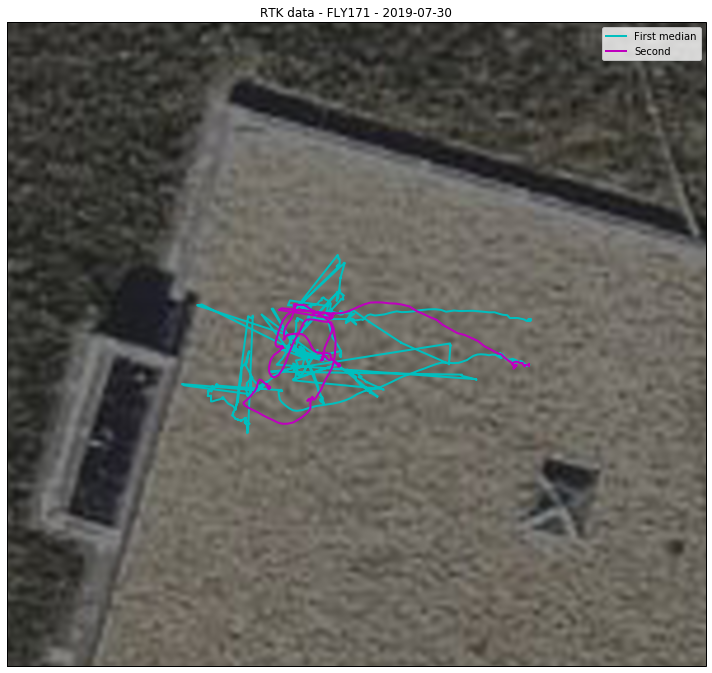

In [14]:
# plot the two tests against each other

# begin the plot
print("started figure")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) # add a subplot in the coordinate system of the tiles
print('setting axes')
ax.set_extent([min(rtk_first["Lon"].values)-BORDER, max(rtk_first["Lon"].values)+BORDER, 
    min(rtk_first["Lat"].values)-BORDER, max(rtk_first["Lat"].values)+BORDER], crs=ccrs.Geodetic()) # set plot size
print("adding image")
ax.add_image(PLOT_BG, 20, interpolation='spline36') # go get some map tiles
# plot the RTK gps data
print("plotting")
plt.plot(rtk_first["medLon"].values, rtk_first["medLat"].values, 'c', linewidth=2, transform=ccrs.Geodetic(), label="First median")
#plt.plot(rtk_first["avMovLon"].values, rtk_first["avMovLat"].values, 'k', linewidth=2, transform=ccrs.Geodetic(), label="First mean")
plt.plot(rtk_second["medLon"].values, rtk_second["medLat"].values, 'm', linewidth=2, transform=ccrs.Geodetic(), label="Second")
# label stuff and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("RTK data - "+FILENAME+" - "+str(date))

print("before fig.canvas.draw")
fig.canvas.draw()
print('after fig.canvas.draw')
plt.tight_layout()
plt.savefig("./plots/comparison"+FILENAME+".png")
print("saved plot")
plt.show()

started figure
setting axes
adding image
plotting
before fig.canvas.draw
after fig.canvas.draw
saved plot


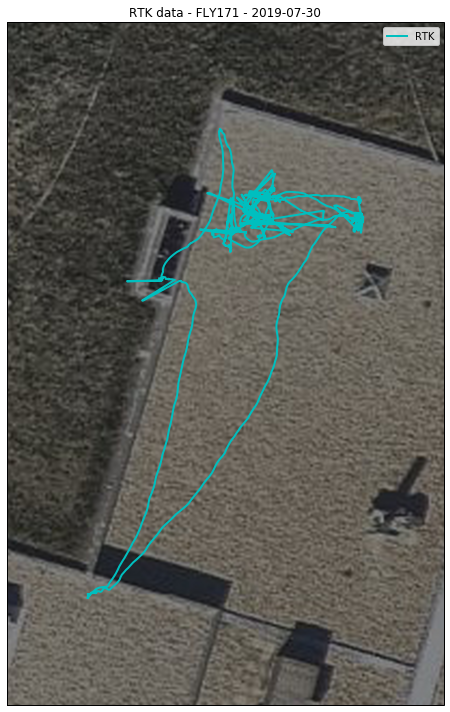

In [15]:

# Plot flight path on top of sattillite imagery

# begin the plot
print("started figure")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) # add a subplot in the coordinate system of the tiles
print('setting axes')
ax.set_extent([min(rtk_p["Lon"].values)-BORDER, max(rtk_p["Lon"].values)+BORDER, 
    min(rtk_p["Lat"].values)-BORDER, max(rtk_p["Lat"].values)+BORDER], crs=ccrs.Geodetic()) # set plot size
print("adding image")
ax.add_image(PLOT_BG, 20, interpolation='spline36') # go get some map tiles
# plot the RTK gps data
print("plotting")
plt.plot(rtk_p["avMovLon"].values, rtk_p["avMovLat"].values, 'c', linewidth=2, transform=ccrs.Geodetic(), label="RTK")
# label stuff and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("RTK data - "+FILENAME+" - "+str(date))

print("before fig.canvas.draw")
fig.canvas.draw()
print('after fig.canvas.draw')
plt.tight_layout()
plt.savefig("./plots/"+FILENAME+".png")
print("saved plot")
plt.show()

<class 'numpy.datetime64'>


/home/annie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/annie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/annie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


<IPython.core.display.Javascript object>


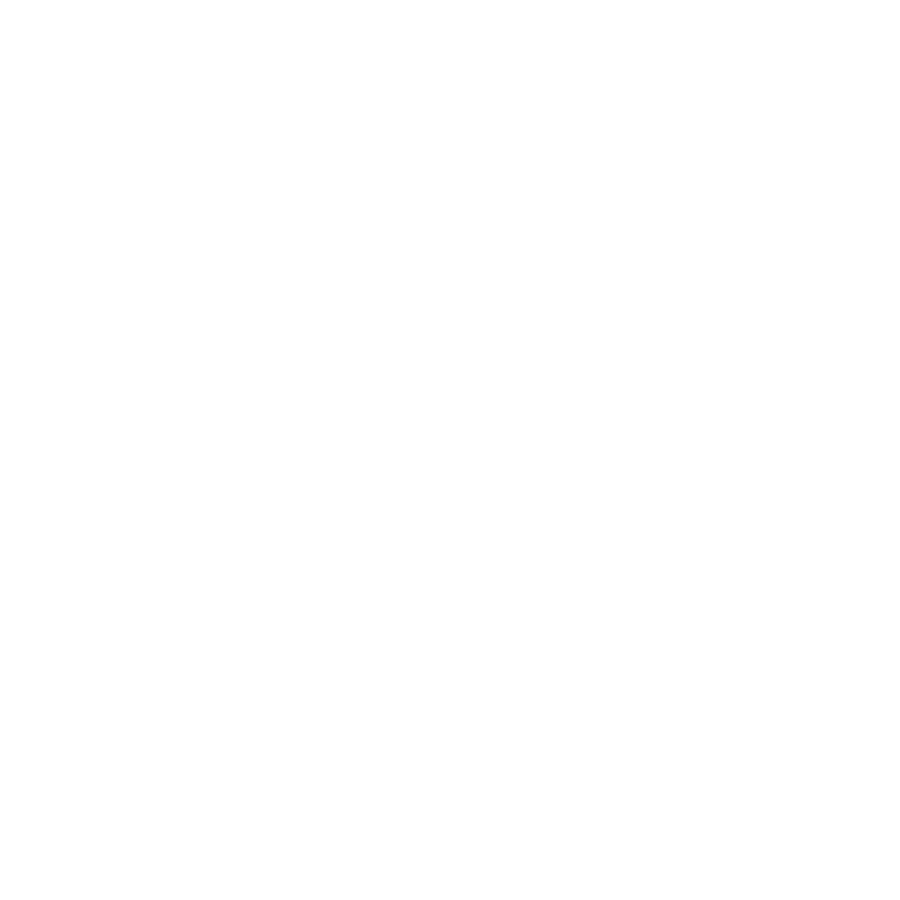

/home/annie/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [16]:
# Plot longitude vs time

print(type(rtk_p['timestamp'].values[0]))
date_format = dates.DateFormatter("%H:%M:%S")

rtk_p = fill_moving(rtk_p, xy_thresh= 0.0000002, win=200) #0.00000005
rtk_mov = rtk_p[rtk_p["isMoving"] == True]
rtk_stop = rtk_p[rtk_p["isMoving"] == False]

%matplotlib notebook
fig = plt.figure(figsize=(9,9))
plt.title("Longitude vs Seconds Elapsed")
plt.ylim(min(rtk_p["Lon"].values), max(rtk_p["Lon"].values))
#plt.plot(rtk_p["timestamp"].values, rtk_p["Lon"].values)
plt.scatter(rtk_mov['timestamp'].values, rtk_mov['Lon'].values, s=2, color='c')
plt.scatter(rtk_stop['timestamp'].values, rtk_stop["Lon"].values, s=2, color='m')
plt.grid()
ax = plt.gca()
ax.yaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_minor_formatter(LONGITUDE_FORMATTER)
ax.xaxis.set_major_formatter(date_format)
plt.xlim(min(rtk_p['timestamp'].values),max(rtk_p["timestamp"].values))
plt.tight_layout()
plt.savefig("./plots/"+FILENAME+"_lon.png")
plt.show()

<IPython.core.display.Javascript object>


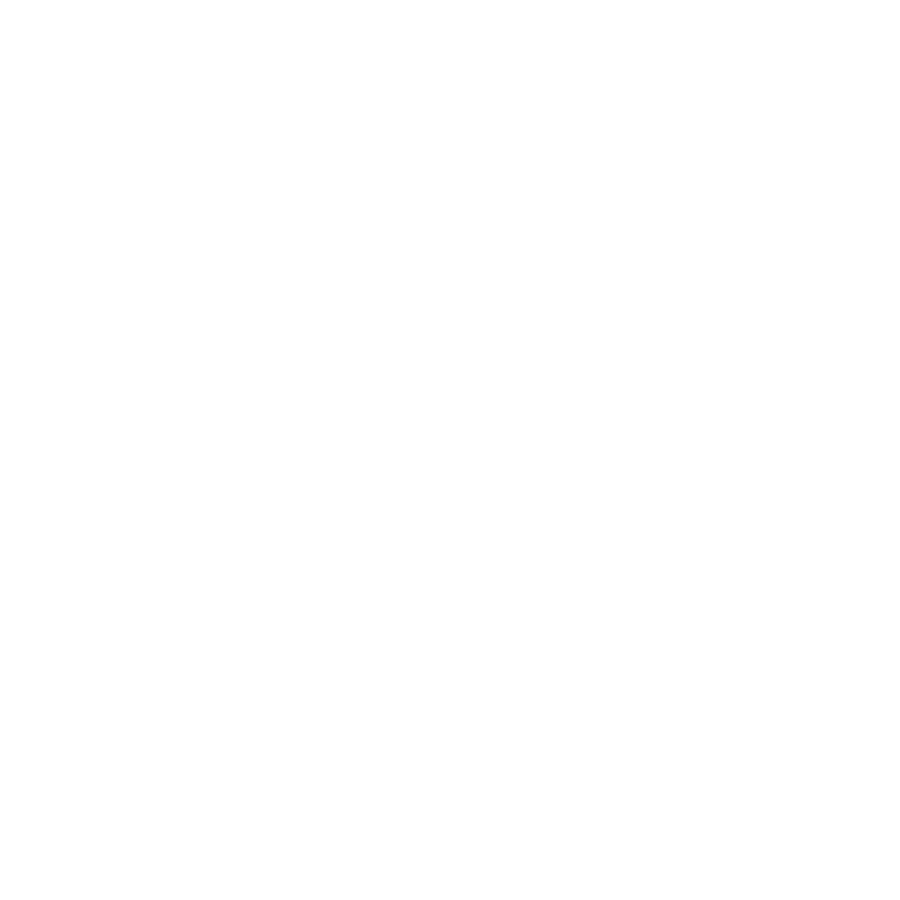

In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(9,9))
plt.title("Latitude vs Seconds Elapsed")
plt.ylim(min(rtk_p["Lat"].values), max(rtk_p["Lat"].values))
#plt.plot(rtk_p["timestamp"].values, rtk_p["Lon"].values)
plt.scatter(rtk_mov['timestamp'].values, rtk_mov['Lat'].values, s=2, color='c')
plt.scatter(rtk_stop['timestamp'].values, rtk_stop["Lat"].values, s=2, color='m')
plt.grid()
ax = plt.gca()
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
ax.yaxis.set_minor_formatter(LATITUDE_FORMATTER)
ax.xaxis.set_major_formatter(date_format)
plt.xlim(min(rtk_p['timestamp'].values),max(rtk_p["timestamp"].values))
plt.tight_layout()
plt.savefig("./plots/"+FILENAME+"_lat.png")
plt.show()

<IPython.core.display.Javascript object>


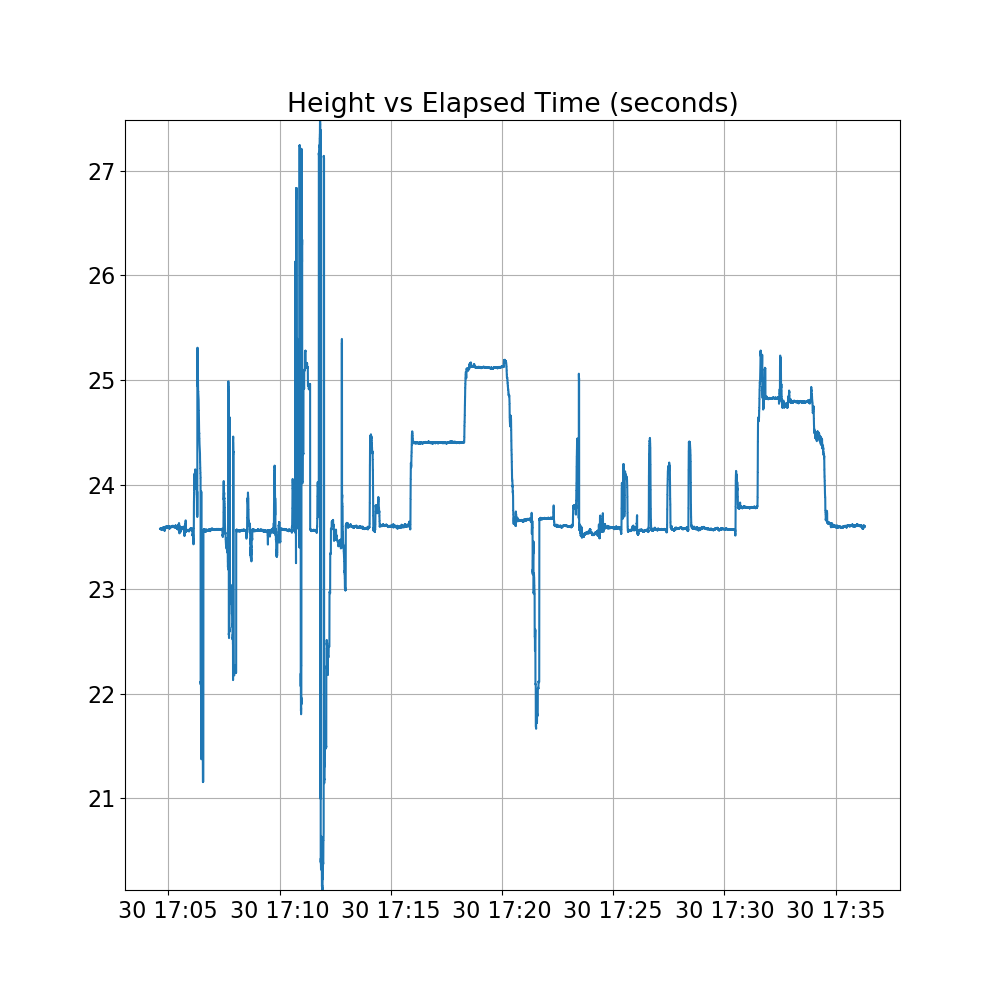

<IPython.core.display.Javascript object>


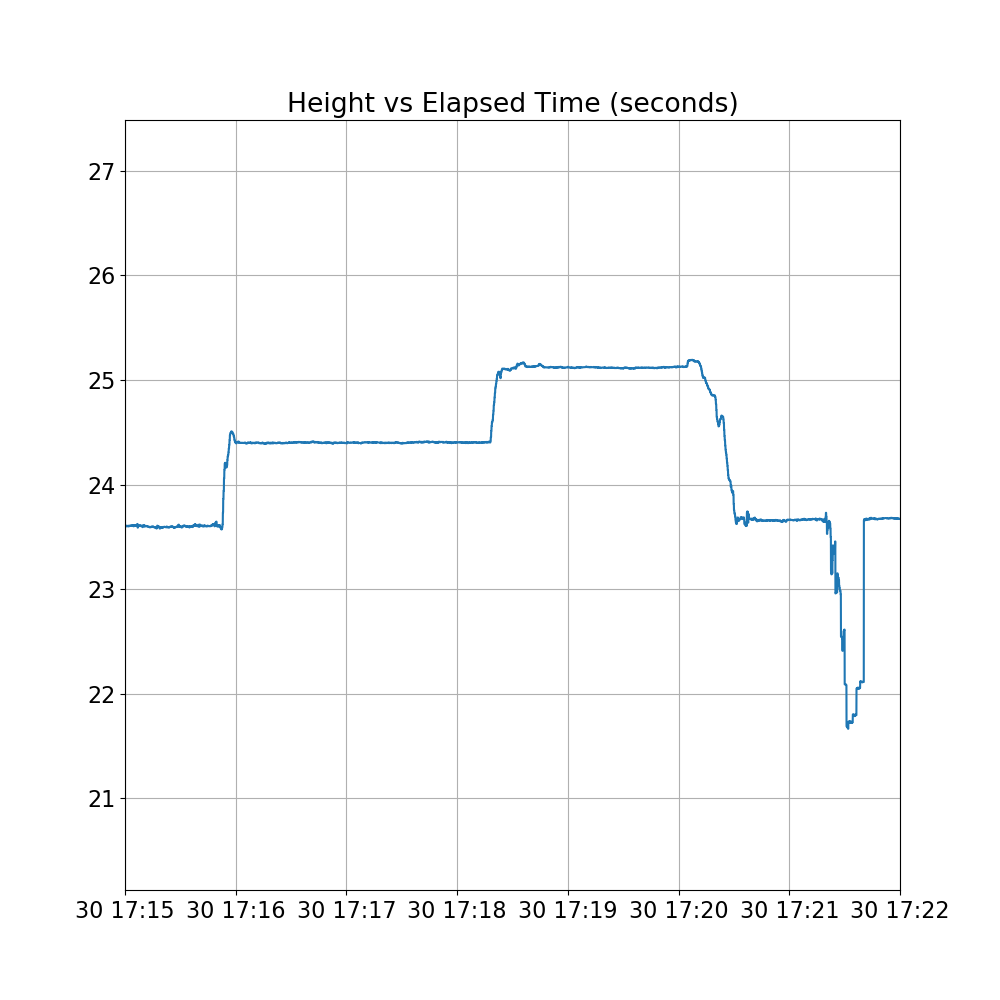

In [18]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
plt.title("Height vs Elapsed Time (seconds)")
plt.ylim(min(rtk_p["hmsl"].values), max(rtk_p["hmsl"].values))
plt.plot(rtk_p["timestamp"].values, rtk_p["hmsl"].values)
plt.grid()
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_minor_formatter(date_format)
plt.savefig("./plots/"+FILENAME+"_hmsl.png")
plt.show()

fig = plt.figure(figsize=(10,10))
plt.title("Height vs Elapsed Time (seconds)")
plt.ylim(min(rtk_p["hmsl"].values), max(rtk_p["hmsl"].values))
plt.plot(rtk_p["timestamp"].values, rtk_p["hmsl"].values)
plt.grid()
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_minor_formatter(date_format)
plt.xlim(np.datetime64("2019-07-30T17:15:00"), np.datetime64("2019-07-30T17:22:00"))
plt.savefig("./plots/"+FILENAME+"_hmsl.png")
plt.show()

<IPython.core.display.Javascript object>


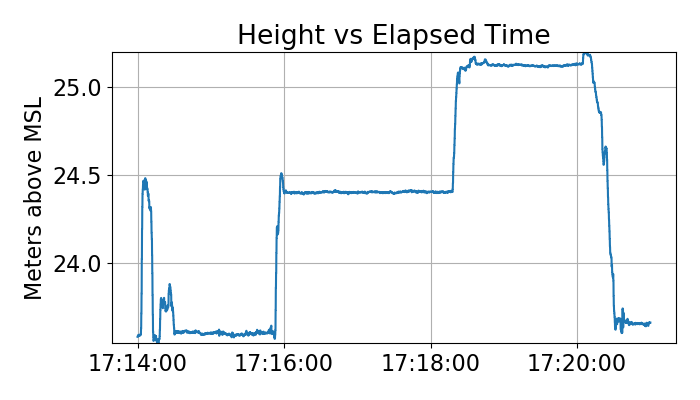

Middle position offset: 0.7993551664019414
Top position offset: 1.5163467326611588


In [27]:
z_test = chopTime(rtk_p, np.datetime64("2019-07-30T17:14:00"), np.datetime64("2019-07-30T17:21:00"))
fig = plt.figure(figsize=(7,4))
plt.title("Height vs Elapsed Time")
ax = plt.gca()
plt.ylim(min(z_test["hmsl"].values), max(z_test["hmsl"].values))
plt.plot(z_test["timestamp"].values, z_test["hmsl"].values)
plt.ylabel("Meters above MSL")
plt.grid()
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_minor_formatter(date_format)
ax.set_xticks(ax.get_xticks()[::2])
plt.tight_layout()
plt.savefig("./plots/cut_"+FILENAME+"_hmsl.png")
plt.show()

bottom = chopTime(rtk_p, np.datetime64("2019-07-30T17:14:40"), np.datetime64("2019-07-30T17:15:45"))
middle = chopTime(rtk_p, np.datetime64("2019-07-30T17:16:10"), np.datetime64("2019-07-30T17:18:15"))
upper  = chopTime(rtk_p, np.datetime64("2019-07-30T17:19:00"), np.datetime64("2019-07-30T17:20:00"))
bot_height = np.mean(bottom['hmsl'].values)
mid_height = np.mean(middle['hmsl'].values)
top_height = np.mean(upper['hmsl'].values)
print("Middle position offset: "+str(mid_height-bot_height))
print("Top position offset: "+str(top_height-bot_height))

<IPython.core.display.Javascript object>


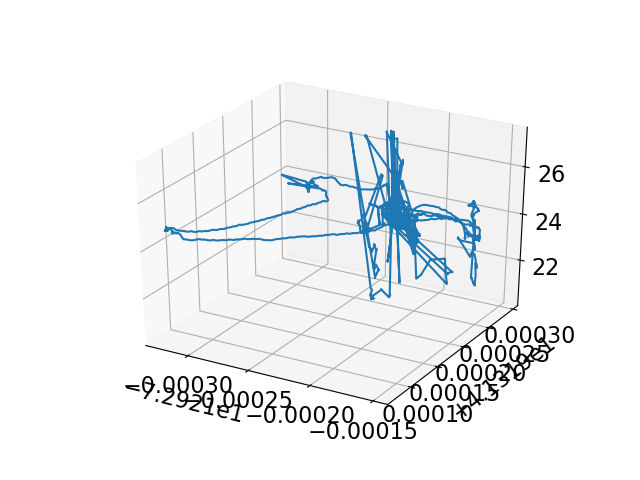

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(rtk_p['Lon'].values, rtk_p['Lat'].values, rtk_p['hmsl'].values)
plt.savefig("./plots/3d"+FILENAME+".png")
plt.show()

In [21]:
#print(type(rtk_p))
if(FILENAME == "FLY171"):
    if("point" in rtk_p.columns): rtk_p = rtk_p.drop(columns=['point'])
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:06:59"), thresh = 0.01)
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:09:13"), thresh = 0.01)
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:10:18"), thresh = 0.008)
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:11:37"), thresh = 0.009)
    #rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:13:29"), thresh = 0.01)
    #rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:13:29"), thresh = 0.01)
    #rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:13:29"), thresh = 0.01)

    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:24:03"), thresh = 0.01)
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:24:49"), thresh = 0.01)
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:26:14"), thresh = 0.01)
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:27:08"), thresh = 0.01)
    #rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:28:00"), thresh = 0.01)
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-30T17:29:00"), thresh = 0.01)


if(FILENAME == "FLY147_FLY148"):
    if("point" in rtk_p.columns): rtk_p = rtk_p.drop(columns=['point'])
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T19:54:59"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T19:55:53"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T19:56:33"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T19:57:30"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T19:58:11"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T19:58:46"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T19:59:30"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:00:06"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:00:36"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:01:08"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:01:42"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:02:22"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:02:58"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:03:27"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:04:16"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:04:59"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:05:33"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:05:58"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:06:30"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:07:01"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:07:29"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:07:59"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:08:22"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:08:48"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-11T20:09:21"))
    print(rtk_p['point'].values)


if(FILENAME == "FLY153"):
    if("point" in rtk_p.columns): rtk_p = rtk_p.drop(columns=['point'])
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-26T18:32:29"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-26T18:33:35"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-26T18:35:01"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-26T18:35:49"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-26T18:36:42"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-26T18:37:40"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-26T18:38:35"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-26T18:39:21"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-26T18:40:11"))
    rtk_p = markPoint(rtk_p, np.datetime64("2019-07-26T18:41:20"))
    print(rtk_p['point'].values)

#rtk_p = makeENU(rtk_p, lat_origin=41.320496, lon_origin=-72.922405, height_origin=42.5)
#outputPoints(rtk_p)

2019-07-30T17:06:54.390000000
2019-07-30T17:07:26.400000000
-1
2019-07-30T17:08:56.794000000
2019-07-30T17:09:25.007000000
0
2019-07-30T17:10:03.997000000
2019-07-30T17:10:32.817000000
1
2019-07-30T17:11:30.597000000
2019-07-30T17:11:38.402000000
2
2019-07-30T17:23:58.354000000
2019-07-30T17:24:15.557000000
3
2019-07-30T17:24:44.947000000
2019-07-30T17:24:59.382000000
4
2019-07-30T17:26:08.151000000
2019-07-30T17:26:24.183000000
5
2019-07-30T17:26:52.367000000
2019-07-30T17:27:22.357000000
6
2019-07-30T17:28:53.148000000
2019-07-30T17:29:13.960000000
7


<IPython.core.display.Javascript object>


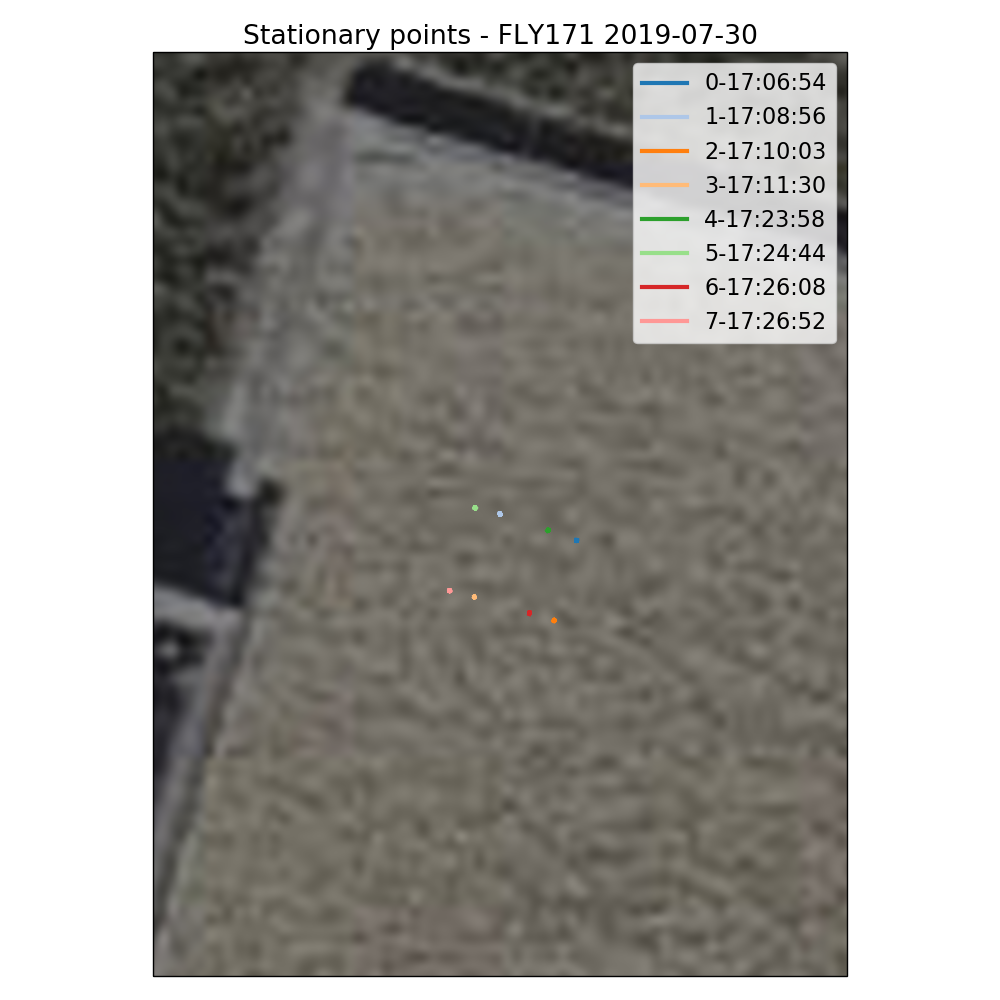

3077
2710
2774
751
1647
1379
1539
2875
saved plot


In [22]:

# begin the plot
fig = plt.figure(figsize=(10,10))

# set up a color map
cm = plt.get_cmap('tab20') #gist_ncar, tab20

ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) # add a subplot in the coordinate system of the tiles
ax.set_prop_cycle(color=[cm(1.*i/20) for i in range(20)])
i=1
ax.set_extent([min(rtk_p[rtk_p['point'] == i]['Lon'].values)-BORDER, max(rtk_p[rtk_p['point'] == i]['Lon'].values)+BORDER, 
    min(rtk_p[rtk_p['point'] == i]['Lat'].values)-BORDER, max(rtk_p[rtk_p['point'] == i]['Lat'].values)+BORDER], crs=ccrs.Geodetic()) # set plot size
ax.add_image(PLOT_BG, 20, interpolation='spline36') # go get some map tiles

# plot each point
for i in range(max(rtk_p['point'].values)):
    lat = rtk_p[rtk_p['point'] == i]['avMovLat'].values
    lon = rtk_p[rtk_p['point'] == i]['avMovLon'].values
    print(len(rtk_p[rtk_p['point'] == i]['Lat'].values))
    
    plt.plot(lon, lat, transform=ccrs.Geodetic(), linewidth=3.0, label=str(i)+"-"+str(rtk_p[rtk_p['point']==i]['timestamp'].values[0])[11:19])
    #plt.errorbar(np.mean(lat), np.mean(lon), xerr=np.std(lat), yerr=np.std(lon), color = 'm', zorder=10)
    
# label stuff and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Stationary points - "+FILENAME+" "+str(date))
plt.grid()
fig.canvas.draw()
plt.tight_layout()
plt.savefig("./plots/points_"+FILENAME+".png")
print("saved plot")
plt.show()


In [23]:
print("All lengths in meters")
print("Side lengths: ")
print(distBetweenPoints(rtk_p, 0, 1))
print(distBetweenPoints(rtk_p, 1, 3))
print(distBetweenPoints(rtk_p, 2, 3))
print(distBetweenPoints(rtk_p, 2, 0))

print("Shift over 15 minutes: ")
print(distBetweenPoints(rtk_p, 0, 4))
print(distBetweenPoints(rtk_p, 1, 5))
print(distBetweenPoints(rtk_p, 2, 6))
print(distBetweenPoints(rtk_p, 3, 7))


All lengths in meters
Side lengths: 
0.9775825269146062
1.0450494429626098
1.0039237011184026
0.9966579513513887
Shift over 15 minutes: 
0.3641967905772069
0.31152877243579613
0.31215153706369686
0.30919101878164484
